# Ejercicio: Simulación del modelo de Ising en 2D

## Descripción del Problema

El ejercicio consiste en simular en el ordenador el modelo de Ising en 2D para una temperatura T. En una red cuadrada con $N \times N$ variables de spin $s_i$ que pueden tomar los valores $\{+1,-1\}$. El sistema viene descrito por el siguiente hamiltoniano:

$$ H = -J \sum_{<i,j>} s_i s_j$$

Para simplificar el tratamiento del problema, se va a trabajar en unidades tales que $k_B=J=1$ y el parametro $\beta=1/T$. La simulación se realizará siguiendo el algoritmo de Metropolis, obteniendo configuraciones más favorables energéticamente de forma aleatoria mediante el cambio al azar de uno de los spines. El procedimiento del algoritmos se puede resumir en los siguientes pasos:

1. Se establece un estado inicial aleatorio para todos los spines del la red entre $\{+1,-1\}$.
2. Se elegige un spin $s_i$ de la red al azar y se calcula la contribución a la energía total de ese spin (con las cuatro contribuciones de los spines contiguos).
3. Se cambia el spin de signo ($s_i \rightarrow - s_i$) y se calcula la energía del estado del sistema (unicamente se requiere calcular los cuatro terminos de interacción contiguos).
4. Si nuevo estado (con el spin cambiado) tiene una energía menor que la anterior, se acepta el cambio. Si la energía del nuevo estado es mayor, se acepta el cambio con probabilidad $\exp(-\beta(H_f-H_0))$.
5. Se vuelve a elegir un spin al azar y se repite el proceso tantas veces como se requiera.

Es importante remarcar que para cada paso de tiempo del sistema, se han de realizar como mínimo $N \times N$ ciclos del algoritmo. El ejercicio consiste en implementar la simulación menciona y estudiar algunas propiedades de sus soluciones.

## Implementación

Dado que se van a simular sistemas razonablemente grandes (e.g. $100 \times 100$) y se requieren muchos ciclos de Metrópolis, se ha optado por implementar la simulación en C++ para obtener un alto rendimiento. Además, para facilitar el manejo del simulador y el análisis de los resultados se ha implentado una interfaz en Python utilizando Cython. El código de fuente del simulador, de la interfaz y de este documento (es un IPython Notebook) estan disponibles [online](https://github.com/pablodecm/ising_model).

## Resultados

In [1]:
# import Python scientific libraries and simulator interface
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from Ising import IsingSimulator

En primer lugar, se va representar graficamente la evoluación temporal de la magnetización total (normalizada), $M=\sum_i s_i$, con el tiempo para diferentes temperaturas:

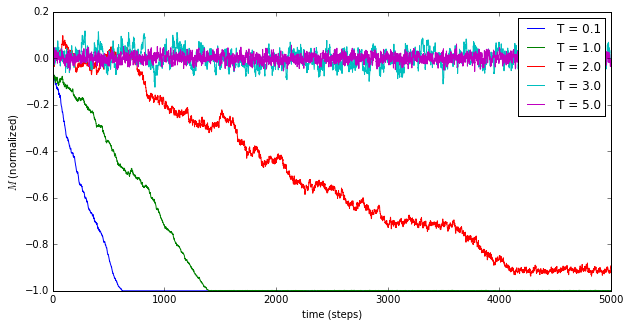

In [2]:
fig, ax = plt.subplots(figsize = (10,5))
size = 100 # 100 x 100 grid
n_steps = 5000
temp_array = [0.1,1.0,2.0,3.0,5.0]
for temp in temp_array:
    ising = IsingSimulator(size, temp)
    meanMag = np.array(ising.simulate(n_steps))
    steps = np.linspace(0,n_steps-1, n_steps, dtype=int)
    ax.plot(steps, meanMag, label = "T = {:.2}".format(temp))
x_label = ax.set_xlabel("time (steps)")
y_label = ax.set_ylabel("$M$ (normalized)")
leg = plt.legend()

En los resultados de la simulación anteriores, se aprecia una magnetización neta para temperaturas $T < 2$. Partiendo de un estado inicial aleatorio, para $T=0.1$ y $T=1.0$ todos los spines de la región de simulación se magnetizan en la misma dirección al cabo de un cierto tiempo (mayor para $T$ más grandes). Para $T>3$ se observa que el sistema fluctúa entorno a una magnetización nula a lo largo del tiempo. Se observa un comportamiento peor definido para $T=2$, posiblemente porque dicha temperatura sea cercana al punto crítico.

A continuación, se va a obtener la magnetización total promediada en el tiempo en función de la temperatura. Con el objetivo de evitar que el estado inicial condicione el resultado, se va a promediar despues de $10000$ pasos de tiempo.

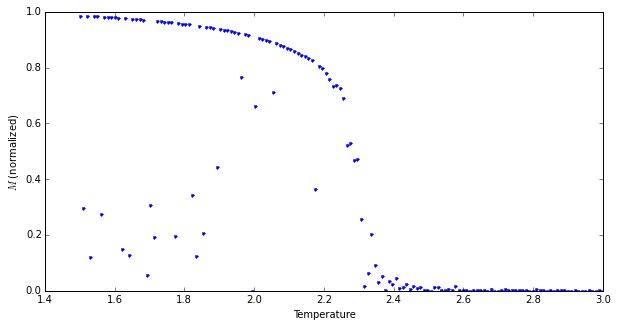

In [3]:
fig, ax = plt.subplots(figsize = (10,5))
size = 100 # 100 x 100 grid
n_steps_warm_up = 10000 # to avoid to be affected by initial conditions
n_steps = 10000
n_points = 150
temp_array = np.linspace(1.5,3.0, n_points)
mag_array = np.zeros(n_points)
for i, temp in enumerate(temp_array):
    ising = IsingSimulator(size, temp)
    ising.simulate(n_steps_warm_up)
    mag_array[i] = np.abs(np.mean(np.array(ising.simulate(n_steps))))
ax.plot(temp_array, mag_array, ".")
x_label = ax.set_xlabel("Temperature")
y_label = ax.set_ylabel("$M$ (normalized)")

Los resultados obtenidos son coherentes con lo esperado, se observa un cambio de comportamiento de la magnetización alrededor de un punto crítico, es decir, una transición de fase. Para temperaturas $T < 2.4$ se observa una magnetización neta (que se incrementa conforme la temperatura disminuye). Para $ T > 2.4$ la magnetización media es nula. Por lo tanto, la temperatura crítica es aproximadamente $T_c \approx 2.4$. Algunos puntos presentan magnetizaciones intermedias que no se ajustan a la tendencia general por que se forman grandes dominios simétricos que son estables.

A continuación, se va a experimentar con la rotura espontanea de la simetría para $T<T_c$. En concreto, se va a simular el sistema para $T=1.5$ repetidas veces y se va estudiar el signo de la magnetización.

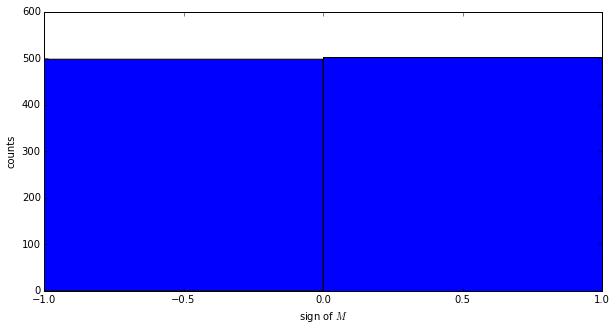

In [4]:
fig, ax = plt.subplots(figsize = (10,5))
size = 100 # 100 x 100 grid
temp = 1.5
n_times = 1000
n_steps_warmup = 100
n_steps = 100
mag_array = np.zeros(n_times)
ising = IsingSimulator(size, temp)
for i in range(n_times):
    ising.initLatticeRandom()
    ising.simulate(n_steps_warmup)
    mag_array[i] = np.array(ising.simulate(n_steps))[-1]
# get sign of magnetization
sign_mag_array = np.sign(mag_array)
ax.hist(sign_mag_array, bins = [-1.0,0.0,1.0])
x_label = ax.set_xlabel(u"sign of $M$")
y_label = ax.set_ylabel(u"counts")

Se aprecia que el signo de la magnetización es positivo o negativo con la misma probabilidad (teniendo en cuenta el tamaño de la muestra). El resultado obtenido es compatible con los esperado, ya que la rotura espontanea de simetría causará que el sistema se oriente en una dirección en función de cualquier  fluctuación (que es aleatoria y con igual probabilidad en este caso).

Por último, se van a representar graficamente la red para diferentes temperaturas con el objetivo de apreciar cualitativamente la correlación y su naturaleza fractal cerca del punto crítico.

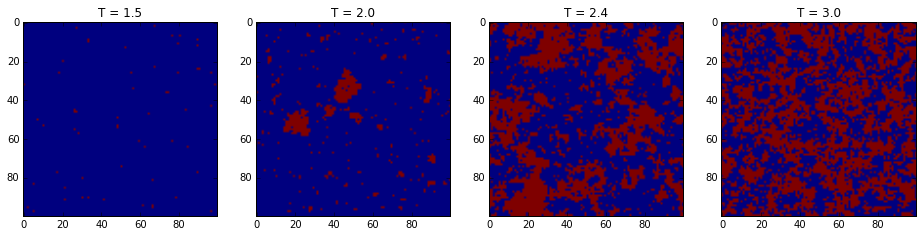

In [7]:
fig, axarr = plt.subplots(1,4, figsize = (16,4))
size = 100 # 100 x 100 grid
temp_array = [1.5, 2.0, 2.4, 3.0]
for i, temp in enumerate(temp_array):
    ising.initLatticeRandom()
    ising.setTemperature(temp)
    ising.simulate(10000)
    axarr[i].imshow(np.array(ising.getLattice()))
    axarr[i].set_title("T = {:.2}".format(temp))

Para la temperatura más baja utilizada ($T=1.5$), se aprecia que practicamente todos lo spines del sistema estan orientados en la misma dirección. Conforme la temperatura aumenta, se van formando pequeños dominios. Muy cerca de la temperatura crítica, se apreciam dominios de de diferentes tamaños (fluctuaciones a todas las scalas, carácteristicas de la naturaleza fractal del punto crítico) y ninguna de las orientaciones domina. Cuando se aumenta más al temperatura, disminuye la correlación entre los dominios y no se aprecia ninguna forma característica.